In [13]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import WhitespaceTokenizer
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
from time import time
import pickle
import sys

In [14]:
# Ensure nltk resources are downloaded
# Commented because already downloaded
# nltk.download('stopwords')
# nltk.download('wordnet')

In [15]:
# Load and preprocess the dataset
def load_and_preprocess_data(file_path, location='Penang'):
    try:
        df = pd.read_csv(file_path)
        # Ensure 'Restaurant' column is included
        df = df[df['Location'] == location]
        df = df[['Review', 'Rating', 'Restaurant']]
        df.drop_duplicates(inplace=True)
        df.reset_index(drop=True, inplace=True)
        df["Label"] = df["Rating"].apply(lambda x: 2 if x > 3 else 0 if x < 3 else 1)
        return df
    except Exception as e:
        print(f"Error loading data: {e}")
        return None

In [16]:
# Balance the dataset
def balance_dataset(X, y):
    smote = SMOTE()
    X_res, y_res = smote.fit_resample(X, y)
    return X_res, y_res

In [17]:
# Clean text data
def clean_text(series, stop_words):
    lemmatizer = WordNetLemmatizer()
    tokenizer = WhitespaceTokenizer()

    def expand_contractions(text, contractions_dict):
        contractions_pattern = re.compile('({})'.format('|'.join(contractions_dict.keys())), flags=re.IGNORECASE|re.DOTALL)
        def expand_match(contraction):
            match = contraction.group(0)
            first_char = match[0]
            expanded_contraction = contractions_dict.get(match if match in contractions_dict else match.lower(), match)
            return first_char + expanded_contraction[1:]
        expanded_text = contractions_pattern.sub(expand_match, text)
        return expanded_text

    contractions_dict = {
        "isn't": "is not",
        "aren't": "are not",
        "can't": "cannot",
        "couldn't": "could not",
        "didn't": "did not",
    }

    series = series.str.lower()
    series = series.apply(lambda x: expand_contractions(x, contractions_dict))
    series = series.str.replace('[^\x00-\x7F]+', ' ', regex=True)
    series = series.str.replace('\W', ' ', regex=True)
    series = series.str.replace('\d+', ' ', regex=True)
    series = series.apply(lambda x: ' '.join(word for word in x.split() if word not in stop_words))
    series = series.apply(lambda x: ' '.join(lemmatizer.lemmatize(word) for word in tokenizer.tokenize(x)))
    
    return series

In [27]:
# Function to visualize data balancing
def visualize_data_balancing(original_df, balanced_df):
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    # Original dataset distribution
    original_counts = original_df['Label'].value_counts().sort_index()
    original_counts.index = ['Negative', 'Neutral', 'Positive']
    original_counts.plot(kind='bar', ax=axes[0], color=['red', 'blue', 'green'], title='Original Label Distribution')
    axes[0].set_ylabel('Count')
    axes[0].set_xlabel('Sentiment')

    # Balanced dataset distribution
    balanced_counts = balanced_df['Label'].value_counts().sort_index()
    balanced_counts.index = ['Negative', 'Neutral', 'Positive']
    balanced_counts.plot(kind='bar', ax=axes[1], color=['red', 'blue', 'green'], title='Balanced Label Distribution')
    axes[1].set_ylabel('Count')
    axes[1].set_xlabel('Sentiment')

    plt.tight_layout()  # Ensure the plot fits within the display area
    plt.show()

In [39]:
# Plot classification report heatmap with support
def plot_classification_report_heatmap(report):
    report_df = pd.DataFrame(report).transpose()
    
    # Reorder columns to place support last for better visualization
    columns = ['precision', 'recall', 'f1-score', 'support']
    report_df = report_df[columns]
    
    # Plot the heatmap
    plt.figure(figsize=(12, 6))
    sns.heatmap(report_df.iloc[:-1, :-1], annot=True, fmt=".4f", cmap='Blues')
    
    # Add support as additional annotations
    for y, support in enumerate(report_df.iloc[:-1, -1]):
        plt.text(len(columns) - 2, y + 0.5, f'Support: {int(support)}', va='center', ha='center')
    
    plt.title('Testing Set Classification Report Heatmap')
    plt.xlabel('Metrics')
    plt.ylabel('Classes')
    plt.tight_layout()
    plt.show()

In [40]:
# Function to visualize metrics
def visualize_metrics(val_metrics, test_metrics):
    metrics_df = pd.DataFrame({
        'Metric': ['Accuracy', 'Precision', 'Recall', 'F1 Score'],
        'Validation': [val_metrics['accuracy'], val_metrics['precision'], val_metrics['recall'], val_metrics['f1_score']],
        'Test': [test_metrics['accuracy'], test_metrics['precision'], test_metrics['recall'], test_metrics['f1_score']]
    })
    
    metrics_df_melted = metrics_df.melt(id_vars='Metric', var_name='Dataset', value_name='Score')

    plt.figure(figsize=(10, 6))
    sns.barplot(x='Metric', y='Score', hue='Dataset', data=metrics_df_melted)
    plt.title('Validation and Test Metrics Comparison')
    plt.ylim(0, 1)
    for index, row in metrics_df_melted.iterrows():
        plt.text(index // 2, row['Score'], f'{row["Score"]:.2f}', color='black', ha="center", va='bottom')
    plt.tight_layout()  # Ensure the plot fits within the display area
    plt.show()

In [47]:
# Plot confusion matrix with enhanced labels and annotations
def plot_confusion_matrix(y_true, y_pred, labels):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.tight_layout()
    plt.show()

In [42]:
# Aggregate and display top 10 restaurants in Penang based on predictions
def top_10_restaurants_by_rating(df, predictions):
    df['Predicted_Label'] = predictions
    positive_reviews = df[df['Predicted_Label'] == 2]
    top_restaurants = positive_reviews['Restaurant'].value_counts().head(10)
    print("Top 10 Restaurants in Penang based on predicted positive reviews:")
    print(top_restaurants)
    return top_restaurants

In [43]:
# Train and evaluate the Naive Bayes model
def train_and_evaluate_naive_bayes(X_train, y_train, X_val, y_val, X_test, y_test):
    param_grid = {'alpha': [0.1, 0.5, 1.0, 2.0, 5.0]}
    grid_search = GridSearchCV(MultinomialNB(), param_grid, cv=5, scoring='f1_macro')
    grid_search.fit(X_train, y_train)
    
    model = grid_search.best_estimator_
    
    val_predictions = model.predict(X_val)
    test_predictions = model.predict(X_test)
    
    val_metrics = {
        'accuracy': accuracy_score(y_val, val_predictions),
        'precision': precision_score(y_val, val_predictions, average='macro'),
        'recall': recall_score(y_val, val_predictions, average='macro'),
        'f1_score': f1_score(y_val, val_predictions, average='macro')
    }
    
    test_metrics = {
        'accuracy': accuracy_score(y_test, test_predictions),
        'precision': precision_score(y_test, test_predictions, average='macro'),
        'recall': recall_score(y_test, test_predictions, average='macro'),
        'f1_score': f1_score(y_test, test_predictions, average='macro')
    }
    
    return model, val_metrics, test_metrics, test_predictions

In [50]:
# Main script
def main():
    # Load and preprocess data
    df = load_and_preprocess_data("GoogleReview_data_cleaned.csv")
    if df is None:
        return

    # Text cleaning
    stopwordz = stopwords.words("English")
    stopwordz.remove('not')
    df['Cleaned_Review'] = clean_text(df['Review'], stopwordz)
    
    # Feature extraction using TF-IDF
    vectorizer = TfidfVectorizer()
    X = vectorizer.fit_transform(df['Cleaned_Review'])
    y = df['Label']
    
    # Balance the dataset
    X_balanced, y_balanced = balance_dataset(X, y)

    # Visualize data balancing
    visualize_data_balancing(df, pd.DataFrame(X_balanced.toarray(), columns=vectorizer.get_feature_names_out()).assign(Label=y_balanced))
    
    # Split data
    X_train, X_temp, y_train, y_temp = train_test_split(X_balanced, y_balanced, test_size=0.3, random_state=42)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

    # Train and evaluate Naive Bayes model
    model, val_metrics, test_metrics, test_predictions = train_and_evaluate_naive_bayes(X_train, y_train, X_val, y_val, X_test, y_test)

    # Display metrics
    print("Validation Metrics:", val_metrics)
    print("Test Metrics:", test_metrics)

    # Visualize metrics
    visualize_metrics(val_metrics, test_metrics)

    # Plot classification report heatmap
    report = classification_report(y_test, test_predictions, output_dict=True)
    report_df = pd.DataFrame(report).transpose()
    plt.figure(figsize=(12, 6))
    sns.heatmap(report_df.iloc[:-1, :-1], annot=True, fmt=".4f", cmap='Blues')
    plt.title('Testing Set Classification Report Heatmap')
    plt.show()

    # Plot confusion matrix
    plot_confusion_matrix(y_test, test_predictions, labels=['Negative', 'Neutral', 'Positive'])

    # Display top 10 restaurants based on predicted ratings
    top_10_restaurants_by_rating(df, model.predict(vectorizer.transform(df['Cleaned_Review'])))

    # Serialize the model
    with open('naive_bayes_model3.pkl', 'wb') as model_file:
        pickle.dump(model, model_file)

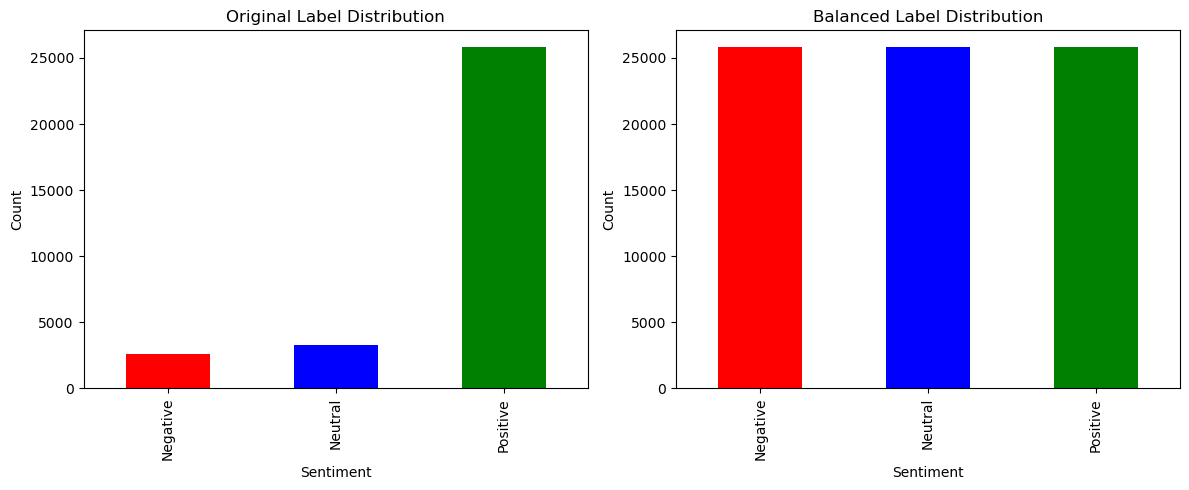

Validation Metrics: {'accuracy': 0.7911643127798829, 'precision': 0.7922661007427779, 'recall': 0.7910027920572116, 'f1_score': 0.7913887055144854}
Test Metrics: {'accuracy': 0.7888391319324837, 'precision': 0.7901121486688337, 'recall': 0.7884405201624395, 'f1_score': 0.7889905763718739}


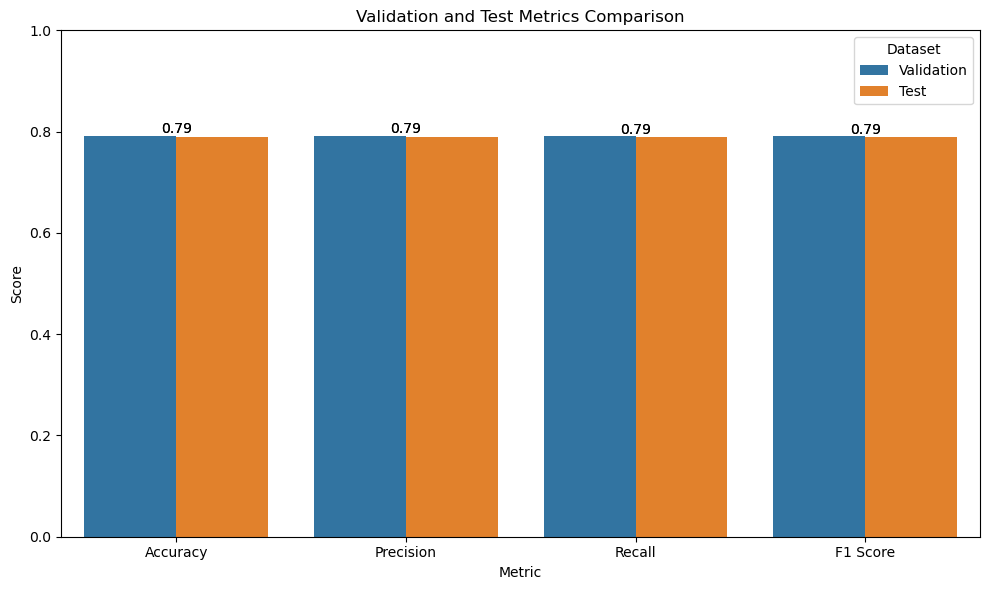

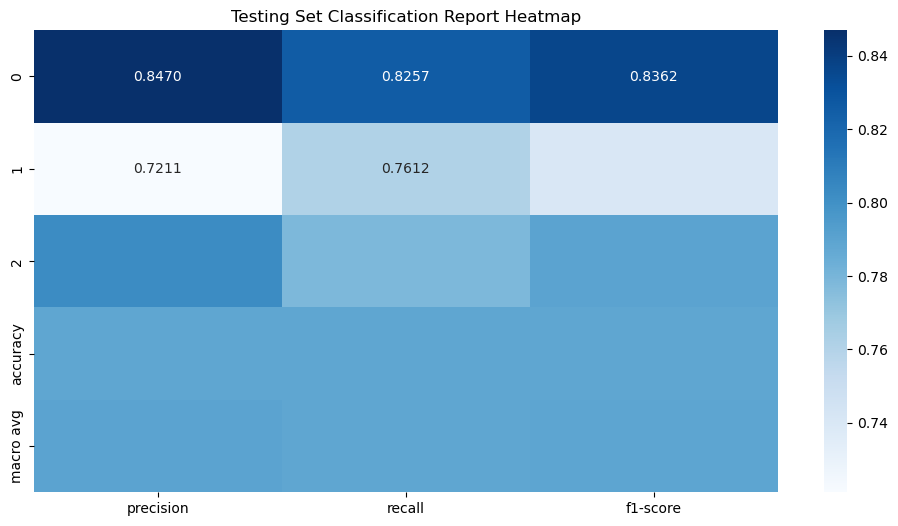

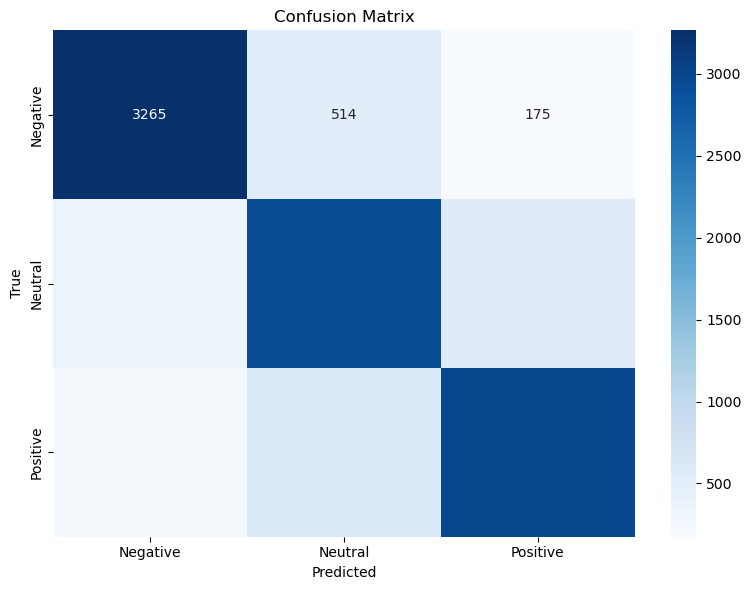

Top 10 Restaurants in Penang based on predicted positive reviews:
Restaurant
Jawi House Cafe Gallery                                                  415
Lagenda House & Cafe                                                     410
Healy Mac's Irish Bar & Restaurant                                       369
Cheang Kee Restaurant                                                    365
Two Frenchies Cafe Bistro                                                321
Andrew's Kampung                                                         266
Narrow Marrow                                                            263
Let's Meat | American Restaurant | American Food | American Breakfast    249
Via Pre Penang Italian Restaurants                                       238
Olive Kitchen + Bar Penang                                               235
Name: count, dtype: int64


In [51]:
if __name__ == "__main__":
    main()